In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import torch
from pydicom import dcmread
import os
from dvh_from_structures import analyse_structures

In [55]:
data = "/Users/simongutwein/Studium/Masterarbeit/phantom_results"
phantoms = [x for x in os.listdir(data) if not x.startswith(".")]

results = []
for p in phantoms:
    pdir = os.path.join(data, p)
    models = [x for x in os.listdir(pdir) if not x.startswith(".")]
    
    for m in models:
        d = os.path.join(pdir, m)
        gamma = os.path.join(d, "gamma.txt")
        target = os.path.join(d, "target.pt")
        prediction = os.path.join(d, "prediction.pt")
        model = m.split("_")[0]
        pos = int(p.split("P")[1][:3])

        p_dose = np.array(torch.load(prediction))
        t_dose = np.array(torch.load(target))

        with open(gamma, "r") as fin:
            gamma = fin.readlines()[4]
            results.append({
                "pos": pos,
                "model": model,
                "gamma": float(gamma),
                "z_p": p_dose[:,256,100],
                "z_t": t_dose[:, 256, 100],
                "x_p": p_dose[pos+100,:, 100],
                "x_t": t_dose[pos+100, :, 100],
                "y_p": p_dose[pos+100, 256, :],
                "y_t": t_dose[pos+100, 256, :],
            })
        

In [56]:

r = pd.DataFrame(results)
print(r[["pos", "model", "gamma"]])
r.keys()


   pos     model   gamma
0  100  prostate  56.080
1  100     mixed  60.122
2  200  prostate  27.713
3  200     mixed  45.539
4  300  prostate  19.246
5  300     mixed  48.427


Index(['pos', 'model', 'gamma', 'z_p', 'z_t', 'x_p', 'x_t', 'y_p', 'y_t'], dtype='object')

9.095899 8.427950859069824 1.0792538756257959
9.095899 7.718130141496658 1.1785106575659574
7.5916715 6.84438744187355 1.1091820168422968
7.5916715 6.663145303726196 1.1393525310909762
6.4545803 5.878427594900131 1.0980113649110095
6.4545803 5.940141290426254 1.0866038350652878


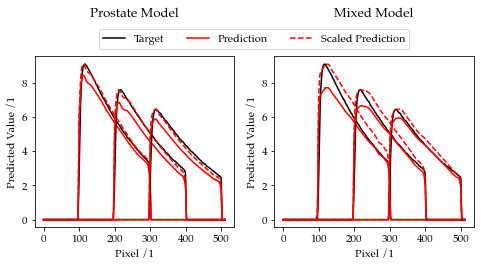

In [58]:
@latex(width=20, height=8, path="/Users/simongutwein/Desktop/scale.pdf")
def irgendwas():
    fig, ax = plt.subplots(1,2, figsize=(12,5))

    for z, pos in zip(r.iterrows(),[100,100,200,200,300,300]):
        if z[1]["model"] == "prostate":
            # peak = z[1]["z_t"].max()
            # ax[0].text(pos+70, peak-0.2, f"{pos} px.")
            fac = z[1]["z_t"].max()/z[1]["z_p"].max()
            print(z[1]["z_t"].max(), z[1]["z_p"].max(), z[1]["z_t"].max()/z[1]["z_p"].max())
            ax[0].plot(z[1]["z_t"], color="black")
            ax[0].plot(z[1]["z_p"], color="red")
            ax[0].plot(z[1]["z_p"]*fac, "--", color="red")

        if z[1]["model"] == "mixed":
            # peak = z[1]["z_t"].max()
            # ax[1].text(pos+70, peak-0.2, f"{pos} px.")
            fac = z[1]["z_t"].max()/z[1]["z_p"].max()
            print(z[1]["z_t"].max(), z[1]["z_p"].max(), z[1]["z_t"].max()/z[1]["z_p"].max())
            ax[1].plot(z[1]["z_t"], color="black")
            ax[1].plot(z[1]["z_p"], color="red")
            ax[1].plot(z[1]["z_p"]*fac, "--", color="red")

        ax[1].set_title("Mixed Model", pad=40)
        ax[1].set_xlabel("Pixel /1")
        ax[1].set_ylabel("Predicted Value /1")
        ax[1].legend(["Target", "Prediction", "Scaled Prediction"], bbox_to_anchor=[-0.1, 1.1], ncol=3, loc="center")
        ax[0].set_title("Prostate Model", pad=40)
        ax[0].set_xlabel("Pixel /1")
        ax[0].set_ylabel("Predicted Value /1")




    return fig

irgendwas()


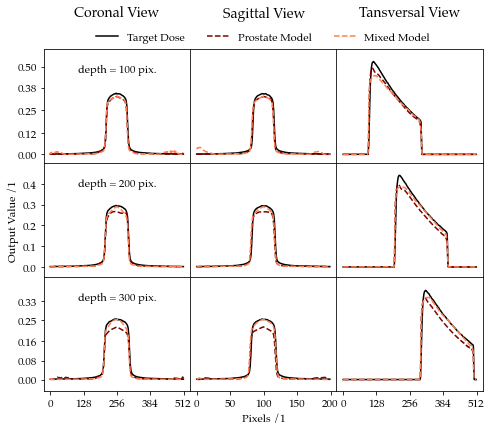

In [59]:
@latex(width=20, height=16, path="/Users/simongutwein/Desktop/quer.pdf")
def plot_2():

    pos = r["pos"].unique()
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    maxs = [0.6, 0.5, 0.43]

    for num ,p in enumerate(pos):
        tmp = r[r["pos"]==p]

        ax[num,0].plot(tmp.iloc[0]["x_t"]*5.811/100, color="Black")
        ax[num,0].plot(tmp.iloc[0]["x_p"]*5.811/100, '--',color="Maroon")
        ax[num,0].plot(tmp.iloc[1]["x_p"]*5.811/100, '--', color="Coral")
        ax[num, 0].set_ylim([-.05, maxs[num]])
        ax[num,0].set_xticks([0, 128, 256, 384, 512])
        ax[num, 0].axes.get_xaxis().set_visible(False)
        ax[num, 0].set_yticks(np.round(np.linspace(0, ax[num, 0].get_ylim()[1]-0.1,5),2))

        ax[num,1].plot(tmp.iloc[0]["y_t"]*5.811/100, color="Black")
        ax[num, 1].plot(tmp.iloc[0]["y_p"]*5.811/100, '--', color="Maroon")
        ax[num,1].plot(tmp.iloc[1]["y_p"]*5.811/100, '--', color="Coral")
        ax[num, 1].set_ylim([-.05, maxs[num]])
        ax[num,1].set_xticks([0,50, 100, 150 ,200])
        ax[num,1].axes.get_yaxis().set_visible(False)
        ax[num, 1].axes.get_xaxis().set_visible(False)

        ax[num,2].plot(tmp.iloc[0]["z_t"]*5.811/100, color="Black")
        ax[num, 2].plot(tmp.iloc[0]["z_p"]*5.811/100, '--', color="Maroon")
        ax[num,2].plot(tmp.iloc[1]["z_p"]*5.811/100, '--', color="Coral")
        ax[num, 2].set_ylim([-.05, maxs[num]])
        ax[num,2].set_xticks([0, 128, 256, 384, 512])
        ax[num,2].axes.get_yaxis().set_visible(False)
        ax[num, 2].axes.get_xaxis().set_visible(False)


    ax[0, 0].text(256,0.8,"Coronal View", va="center",ha="center", fontsize=14, weight="bold")
    ax[0, 1].text(100, 0.8, "Sagittal View", va="center", ha="center", fontsize=14, weight="bold")
    ax[0, 2].text(256, 0.8, "Tansversal View", va="center", ha="center", fontsize=14, weight="bold")
    ax[2, 0].axes.get_xaxis().set_visible(True)
    ax[2, 1].axes.get_xaxis().set_visible(True)
    ax[2, 2].axes.get_xaxis().set_visible(True)
    ax[2,1].set_xlabel("Pixels /1")
    ax[1,0].set_ylabel("Output Value /1")

    ax[0, 0].text(256, .8*ax[0,0].get_ylim()[1], "depth = 100 pix.", va="center", ha="center")
    ax[1, 0].text(256, .8*ax[1,0].get_ylim()[1], "depth = 200 pix.", va="center", ha="center")
    ax[2, 0].text(256, .8*ax[2,0].get_ylim()[1], "depth = 300 pix.", va="center", ha="center")


    legend = ["Target Dose", "Prostate Model", "Mixed Model"]
    ax[0, 1].legend(legend, bbox_to_anchor=(0.5, 1.1), borderaxespad=0, loc="center", ncol=3, frameon=False)
    plt.subplots_adjust(wspace=0, hspace=0)

    return fig

plot_2()


In [4]:
def latex(width, height, path):
    '''Decorator that sets latex parameters for plt'''
    def do_latex(func):
        def wrap(*args, **kwargs):

            plt.rcParams["font.family"] = "serif"
            plt.rcParams["font.serif"] = "Palatino"
            plt.rcParams["font.size"] = 11
            fig = func(*args, **kwargs)
            cm = 1/2.54
            fig.set_size_inches(width*cm, height*cm, forward=True)
            plt.savefig(path, dpi=300, bbox_inches='tight')
        return wrap
    return do_latex


(512, 512)


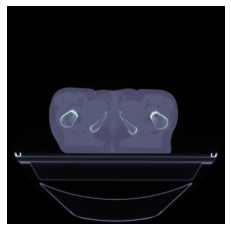

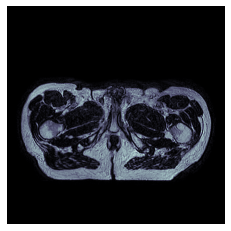

In [90]:
import torch
from pydicom import dcmread, uid
import matplotlib.pyplot as plt
ct = dcmread("/Users/simongutwein/Studium/Masterarbeit/ct_mrt/22_CT/0005733207_CT1_image00060.DCM", force=True)
ct.file_meta.TransferSyntaxUID = uid.ImplicitVRLittleEndian
mrt = dcmread("/Users/simongutwein/Studium/Masterarbeit/ct_mrt/22_MRI/0005733207_T23DTra2min_image00090.DCM", force=True)
mrt.file_meta.TransferSyntaxUID = uid.ImplicitVRLittleEndian
print(ct.pixel_array.shape)
plt.imshow(ct.pixel_array, cmap="bone")
plt.axis("off")
plt.show()
plt.imshow(mrt.pixel_array, cmap="bone")
plt.axis("off")
plt.show()


55.394833


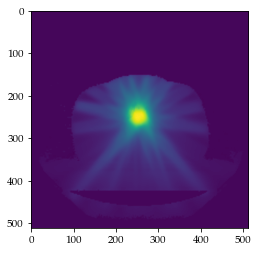

In [499]:
root_dir = "/Users/simongutwein/Desktop/prostate_dvh"
ct_file = os.path.join(root_dir, "CT_image0.dcm")
structure_file = os.path.join(root_dir, "pt3_strctr.dcm")
target_dose = np.array(torch.load(os.path.join(root_dir, "target.pt")))
prediction_dose=np.array(torch.load(os.path.join(root_dir, "prediction.pt")))

print(target_dose.max())
plt.imshow(target_dose[:,:,50])

# with dcmread(ct_file, force=True) as fin:
#     origin = np.array(fin.ImagePositionPatient).astype(float)
#     px_sp = fin.PixelSpacing
#     px_sp.append(3)
#     px_sp = np.array(px_sp).astype(float)
#     print(origin, px_sp)


In [487]:
structures = analyse_structures(structure_file, origin, px_sp, target_dose.shape, target_dose, prediction_dose)

100%|██████████| 31/31 [00:10<00:00,  3.04it/s]


In [489]:
plot_strucs = ["patient", "rectum", "ctv", "bladder", "ptv", "analcanal", "seminal", "femur"]

strucs = []
for struc in structures:
    if any(x in struc["struc_name"].lower() for x in plot_strucs):
        strucs.append(struc)

In [498]:
strucs[0]["target_dvh"]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999997744867883,
 0.9999945876829194,
 0.9999776741920425,
 0.9976614279947591,
 0.9834049337780454,
 0.9585236101056981,
 0.9252554500905436,
 0.8870674938491272,
 0.8460998617604012,
 0.8043785645182023,
 0.7656103627831037,
 0.7306014662869024,
 0.6988728849679658,
 0.6703055478505209,
 0.644442114141257,
 0.6211001436519158,
 0.600133729334533,
 0.5809867556090773,
 0.5640658227962285,
 0.5490743810226122,
 0.5356664930214937,
 0.5234964470393498,
 0.512379773269017,
 0.5021026851858116,
 0.49273373880608795,
 0.48395022472391547,
 0.4758829406020752,
 0.46813611075404854,
 0.4607440131880126,
 0.4535999801548374,
 0.4466584579857611,
 0.4401402241150298,
 0.4339122257477454,
 0.42818982800107347,
 0.42280051326806983,
 0.41764505573559024,
 0.41275277212115474,
 0.40819492459965767,
 0.40392798912124267,
 0.39985995629553955,
 0.3960320950402879,
 0.39253686577228125,
 0.38921753680939397,
 0.3859926978822054,
 0.382971722898386,
 0.38

/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_1349/3559965012.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(-20,101,20)))


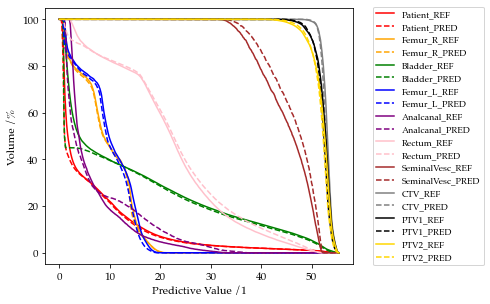

In [204]:
@latex(width=14, height=12, path="/Users/simongutwein/Desktop/dvh_notable.pdf")
def plot():
    fig, ax = plt.subplots(1, 1)

    colorList = ['red', 'orange', 'green', 'blue',
                 'purple', 'pink', 'brown', 'gray', 'black', 'gold']

    legends = ["Patient", "Femur_R", "Bladder", "Femur_L", "Analcanal", "Rectum", "SeminalVesc", "CTV", "PTV1", "PTV2"]
    cols = ("D98 Target / Pred.", "D2 Target / Pred.", "D Mean Target / Pred.", )

    legend = []
    data = []

    

    #sf = 1.1
    for num, struc in enumerate(strucs):

        d98_t = np.round(struc["target_D98"], 2)*sf
        d98_p = np.round(struc["prediction_D98"], 2)*sf

        d2_t = np.round(struc["target_D2"], 2)*sf
        d2_p = np.round(struc["prediction_D2"], 2)*sf

        dmean_t = np.round(struc["target_Dmean"], 2)*sf
        dmean_p = np.round(struc["prediction_Dmean"], 2)*sf

        #print(struc["struc_name"])
        data.append({
            "structure": struc["struc_name"],
            "D2": str(d98_t) + " / " + str(d98_p) + " / " + str(np.round((d98_p-d98_t),4)),
            "D98": str(d2_t) + " / " + str(d2_p) + " / " + str(np.round((d2_p-d2_t),4)),
            "D_mean": str(dmean_t) + " / " + str(dmean_p) + " / " + str(np.round((dmean_p-dmean_t),4))
            })

        ax.plot(struc["dvh_x"], struc["target_dvh"], color=colorList[num])
        ax.plot(struc["dvh_x"], struc["prediction_dvh"], "--", color=colorList[num])
        legend.append(legends[num] + "_REF")
        legend.append(legends[num] + "_PRED")

    # the_table = plt.table(cellText=data,
    #                         rowLabels=legends,
    #                         colLabels=cols,
    #                         loc='bottom',
    #                         colLoc="center",
    #                         bbox=(0,-0.7,1.45,0.55),
    #                         cellLoc="center",
    #                         fontsize=14)

    ax.legend(legend, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=9)
    ax.set_ylabel("Volume /%")
    ax.set_xlabel("Predictive Value /1")
    ax.set_yticklabels(list(range(-20,101,20)))

    #print(pd.DataFrame(data))
    
    return fig



plot()


57 56 35
730.3213836669922
135.7
638.1501281738281


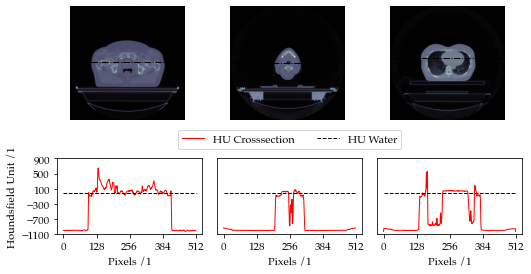

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt

p = 250
h = 255
m = 230

dat_p = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/p35_17/training_data.pt"))[1]
t_p = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/p35_17/target_data.pt"))[0]
sz_p = dat_p.shape
x_p = []
idx_p = np.argwhere(t_p == t_p.max())[0]
for i in range(-2, 2):
    x_p.append(dat_p[p, :, idx_p[2]+i])


x_p = np.array(x_p)
x_p = x_p.mean(axis=0)

dat_h = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/ht0_0/training_data.pt"))[1]
t_h= np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/ht0_0/target_data.pt"))[0]
sz_h = dat_h.shape
x_h = []
idx_h = np.argwhere(t_h == t_h.max())[0]
idx_h[2] = idx_h[2]+10
for i in range(-2,2):
    x_h.append(dat_h[h, :, idx_h[2]+i])


x_h = np.array(x_h)
x_h = x_h.mean(axis=0)

dat_m = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/mt0_0/training_data.pt"))[1]
t_m = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/mt0_0/target_data.pt"))[0]
sz_m = dat_m.shape
x_m = []
idx_m = np.argwhere(t_m == t_m.max())[0]
for i in range(-2, 2):
    x_m.append(dat_m[m, :, idx_m[2]+i])


x_m = np.array(x_m)
x_m = x_m.mean(axis=0)


@latex(width=20, height=10, path="/Users/simongutwein/Desktop/cross.pdf")
def test():
    fig, ax = plt.subplots(2, 3, gridspec_kw={'height_ratios': [3, 2]})
    ax[0, 0].imshow(dat_p[:, :, idx_p[2]], cmap="bone")
    ax[0, 1].imshow(dat_h[:, :, idx_h[2]], cmap="bone")
    ax[0, 2].imshow(dat_m[:, :, idx_m[2]], cmap="bone")

    print(idx_p[2], idx_h[2], idx_m[2])

    ax[0, 0].plot([0, 512], [p, p], "-.", linewidth=1, color="k")
    ax[0, 1].plot([0, 512], [h, h], "-.", linewidth=1, color="k")
    ax[0, 2].plot([0, 512], [m, m], "-.", linewidth=1, color="k")

    ax[1, 0].plot((x_p*1800)-1024, color="red", linewidth=1)
    ax[1, 1].plot((x_h*1800)-1024, color="red", linewidth=1)
    ax[1, 2].plot((x_m*1800)-1024, color="red", linewidth=1)
    ax[1, 0].plot([0, 512], [0, 0], "--", linewidth=1, color="k")
    ax[1, 1].plot([0, 512], [0, 0], "--", linewidth=1, color="k")
    ax[1, 2].plot([0, 512], [0, 0], "--", linewidth=1, color="k")
    ax[1, 1].legend(["HU Crosssection", "HU Water"], bbox_to_anchor=(0.5, 1.25), borderaxespad=0, loc="center", ncol=2)

    ax[0, 0].axis("off")
    ax[0, 1].axis("off")
    ax[0, 2].axis("off")

    for i in range(3):
        print(ax[1, i].get_ylim()[1])
        ax[1, i].set_yticks(np.linspace(-1100, 900, 6))
        ax[1, i].set_xticks([0, 128, 256, 384, 512])
        ax[1, i].set_xlabel("Pixels /1")
        ax[1,i].axes.get_yaxis().set_visible(False)

    ax[1, 0].axes.get_yaxis().set_visible(True)
    ax[1, 0].set_ylabel("Houndsfield Unit /1")
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.1)

    return fig

test()


In [796]:
import pandas as pd

results = "/Users/simongutwein/Desktop/segment_results.pkl"
df = pd.read_pickle(results)
df = df.replace(r'\n', ' ', regex=True)
df

df = pd.melt(df, id_vars = ["segment", "fieldsize"], value_name="gamma", var_name="model")
df.loc[df["model"].str.contains("mix"),"model"] = "Mixed"
df.loc[df["model"].str.contains("pros"), "model"] = "Prostate"

entities = ["pt", "ht", "mt", "lt", "nt"]

df_plan = pd.read_pickle("/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_case_results.pkl")

results = []
for e in entities:
    tmp_df = df.loc[df["segment"].str.contains(e)]
    tmp_df_plan = df_plan.loc[df_plan["plan"].str.contains(e)]


    pros = tmp_df.loc[tmp_df["model"].str.contains("Pros")]["gamma"].astype(float)
    mix = tmp_df.loc[tmp_df["model"].str.contains("Mix")]["gamma"].astype(float)

    pros_plan = tmp_df_plan.loc[tmp_df_plan["model"].str.contains("pros")]["gamma"].astype(float)
    mix_plan = tmp_df_plan.loc[tmp_df_plan["model"].str.contains("mix")]["gamma"].astype(float)

    results.append({
        "entity": e,
        "model": "Prostate",
        "seg_mean":   np.round(pros.mean(),1),
        "seg_median": np.round(pros.median(),1),
        "seg_std": np.round(pros.std(),1),
        "seg_min": np.round(pros.min(),1),
        "seg_max": np.round(pros.max(),1),
        "plan_mean":   np.round(pros_plan.mean(),1),
        "plan_median": np.round(pros_plan.median(),1),
        "plan_std": np.round(pros_plan.std(),1),
        "plan_min": np.round(pros_plan.min(),1),
        "plan_max": np.round(pros_plan.max(),1),
    })

    results.append({
        "entity": e,
        "model": "Mixed",
        "seg_mean": np.round(mix.mean(),1),
        "seg_median": np.round(mix.median(),1),
        "seg_std":  np.round(mix.std(),1),
        "seg_min":  np.round(mix.min(),1),
        "seg_max":  np.round(mix.max(),1),
        "plan_mean": np.round(mix_plan.mean(),1),
        "plan_median": np.round(mix_plan.median(),1),
        "plan_std":  np.round(mix_plan.std(),1),
        "plan_min":  np.round(mix_plan.min(),1),
        "plan_max":  np.round(mix_plan.max(),1),
    })
    

res = pd.DataFrame(results).T

res.to_excel("/Users/simongutwein/Desktop/results.xlsx")




In [793]:
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/segment_results/"
pats = [x for x in os.listdir(root) if "m" in x]
pats

from tqdm import tqdm

results = []
for pat in tqdm(pats):
    segs = [x for x in os.listdir(root + pat) if "m" in x]
    for seg in tqdm(segs):
        with open(os.path.join(root, pat, seg, "prostate_trained_UNET_2234.pt", "gamma.txt"), "r") as fin:
            lines = fin.readlines()
            results.append({
                "seg": seg,
                "model":"pros",
                "gamma": float(lines[-5].strip()),
                "fz": float(lines[-1].replace("tensor(","").replace(")\n",""))
            })

            

        with open(os.path.join(root, pat, seg, "mixed_trained_UNET_1183.pt", "gamma.txt"), "r") as fin:
            lines = fin.readlines()
            results.append({
                "seg":seg,
                "model": "mix",
                "gamma": float(lines[-5].strip()),
                "fz": float(lines[-1].replace("tensor(", "").replace(")\n", ""))
            })

 40%|████      | 2/5 [01:26<02:10, 43.45s/it]


KeyboardInterrupt: 

In [301]:
import pandas as pd

df = pd.DataFrame(results)
df

,seg,model,gamma,fz
0,mt0_0,pros,81.205,79.7304
1,mt0_0,mix,79.695,79.7304
2,mt0_1,pros,78.360,70.8796
3,mt0_1,mix,77.095,70.8796
4,mt0_10,pros,82.810,16.3912
...,...,...,...,...
833,mt4_78,mix,85.070,38.2978
834,mt4_8,pros,71.120,10.3389
835,mt4_8,mix,91.235,10.3389
836,mt4_9,pros,70.170,8.4514


In [302]:
df_tmp = df.loc[df["model"].str.contains("pros")]
print(df_tmp.sort_values("gamma").iloc[:10])
bad_segments = list(df_tmp.sort_values("gamma").iloc[:10]["gamma"])
for s in bad_segments:
    print(s, end=" ")



        seg model    gamma      fz
102  mt0_55  pros   1.8935  2.3330
112   mt0_6  pros   2.3627  2.5605
342  mt2_16  pros   3.0733  5.3290
106  mt0_57  pros   3.2233  3.8893
258  mt1_58  pros   5.7650  3.4712
788  mt4_58  pros   7.3300  2.8190
824  mt4_74  pros   9.2600  2.0261
344  mt2_17  pros  14.9003  5.4375
90    mt0_5  pros  15.8100  2.8592
76   mt0_43  pros  16.9300  6.5090
1.8935 2.3627 3.0733 3.2233 5.765 7.33 9.26 14.9003 15.81 16.93 

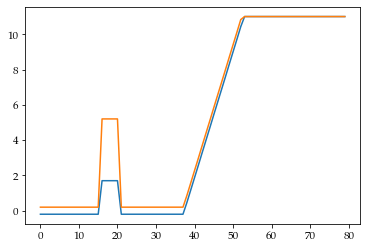

mt0_55





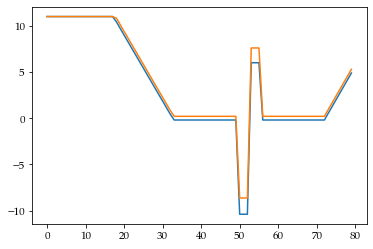

mt0_6





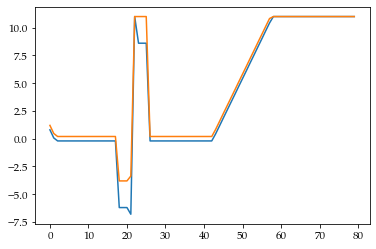

mt2_16





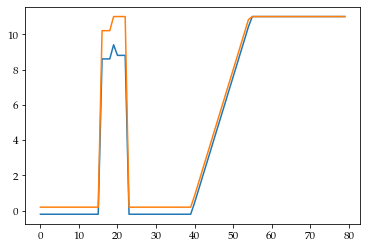

mt0_57





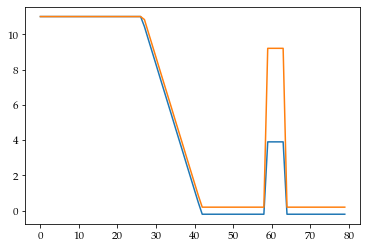

mt1_58





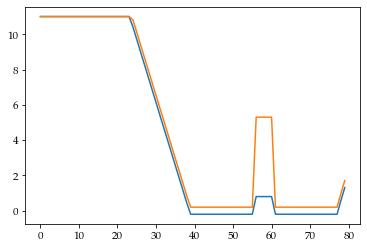

mt4_58





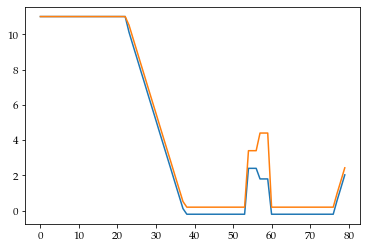

mt4_74





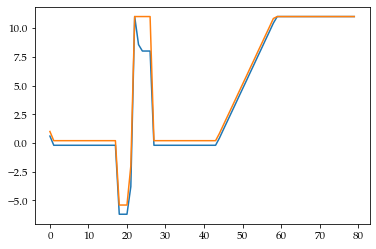

mt2_17





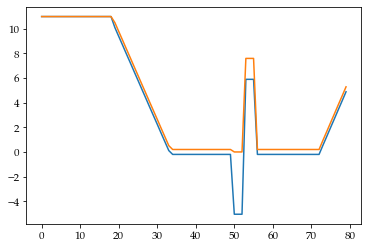

mt0_5





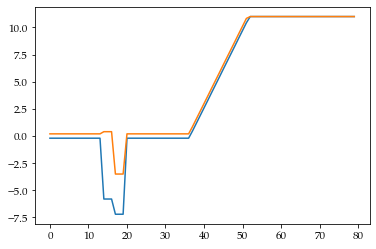

mt0_43





In [59]:
root = "/mnt/qb/baumgartner/sgutwein84/output/output_test"
root2 = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_cases"
for seg in bad_segments:
    with open(os.path.join(root, seg, f"beam_config_{seg}.txt"), "r") as fin:
        lines = fin.readlines()[:-1]
        lines = np.array([x.strip()[:-3].split(",") for x in lines]).astype(float)
        plt.plot(range(len(lines[:,0])),lines[:,0])
        plt.plot(range(len(lines[:, 1])), lines[:, 1])
        plt.show()
        print(seg+"\n\n\n")

    


In [116]:
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/output"
folder = ["output_head", "output_liver", "output_mamma", "output_prostate"]
n = ["h","l","m","p"]

from tqdm import tqdm

info = []
for a, f in zip(n, folder):
    segs = [x for x in os.listdir(os.path.join(root, f)) if not x.startswith(".") and not "ct" in x and not "egsphant" in x]
    
    for s in segs:
        print(s)
        with open(os.path.join(root, f, s, f"beam_config_{s}.txt"), "r") as fin:
            lines = fin.readlines()
            lines = np.array([x.strip()[:-3].split(",") for x in lines]).astype(float)
            idxs = 40+np.round(lines[-1]/0.7125)[0].astype(int), 40+np.round(lines[-1]/0.7125)[1].astype(int)
            lines = lines[:-1,:]
            # plt.plot(range(len(lines[idxs[0]:idxs[1], 0])), lines[idxs[0]:idxs[1], 0])
            # plt.plot(range(len(lines[idxs[0]:idxs[1], 0])), lines[idxs[0]:idxs[1], 1])
            # plt.show()
            diff = np.abs(np.sum(lines[idxs[0]:idxs[1], 0]-lines[idxs[0]:idxs[1], 1])*0.7125)
            
            info.append({
                "seg": s,
                "fz": diff
            })
            # results.append({
            #     "seg": seg,
            #     "model": "mix",
            #     "gamma": float(lines[-5].strip()),
            #     "fz": float(lines[-1].replace("tensor(", "").replace(")\n", ""))
            # })
        





h0_0
h0_1
h0_10
h0_11
h0_12
h0_13
h0_14
h0_15
h0_16
h0_17
h0_18
h0_19
h0_2
h0_20
h0_21
h0_22
h0_23
h0_24
h0_25
h0_26
h0_27
h0_28
h0_29
h0_3
h0_30
h0_31
h0_32
h0_33
h0_34
h0_35
h0_36
h0_37
h0_38
h0_39
h0_4
h0_40
h0_5
h0_6
h0_7
h0_8
h0_9
h1_0
h1_1
h1_10
h1_11
h1_12
h1_13
h1_14
h1_15
h1_16
h1_17
h1_18
h1_19
h1_2
h1_20
h1_21
h1_22
h1_23
h1_24
h1_25
h1_26
h1_27
h1_28
h1_29
h1_3
h1_30
h1_31
h1_32
h1_33
h1_34
h1_35
h1_36
h1_37
h1_38
h1_39
h1_4
h1_40
h1_41
h1_42
h1_43
h1_44
h1_45
h1_46
h1_47
h1_48
h1_49
h1_5
h1_50
h1_51
h1_52
h1_53
h1_54
h1_55
h1_56
h1_57
h1_58
h1_59
h1_6
h1_60
h1_61
h1_62
h1_7
h1_8
h1_9
h2_0
h2_1
h2_10
h2_11
h2_12
h2_13
h2_14
h2_15
h2_16
h2_17
h2_18
h2_19
h2_2
h2_20
h2_21
h2_22
h2_23
h2_24
h2_25
h2_26
h2_27
h2_28
h2_29
h2_3
h2_30
h2_31
h2_32
h2_33
h2_34
h2_35
h2_36
h2_37
h2_38
h2_39
h2_4
h2_40
h2_41
h2_42
h2_43
h2_44
h2_45
h2_46
h2_47
h2_48
h2_49
h2_5
h2_50
h2_51
h2_52
h2_53
h2_54
h2_55
h2_6
h2_7
h2_8
h2_9
h3_0
h3_1
h3_10
h3_11
h3_12
h3_13
h3_14
h3_15
h3_16
h3_17
h3_18
h3_19


In [125]:
df = pd.DataFrame(info)
df.head()

,seg,fz
0,h0_0,143.14125
1,h0_1,74.84100
2,h0_10,62.18700
3,h0_11,14.49225
4,h0_12,117.12075
5,h0_13,13.28100
6,h0_14,11.25750
7,h0_15,30.95100
8,h0_16,107.34525


In [135]:
df.to_pickle("/Users/simongutwein/Desktop/fz_analysis.pkl")

df_tmp = df.loc[df["seg"].str.contains(r'[h,p,l,m][1,2,3,4,5,6,7,8,9,10]_')]
for i in df_tmp.iterrows():
    print(i)

(0, seg         h0_0
fz     143.14125
Name: 0, dtype: object)
(1, seg      h0_1
fz     74.841
Name: 1, dtype: object)
(2, seg     h0_10
fz     62.187
Name: 2, dtype: object)
(3, seg       h0_11
fz     14.49225
Name: 3, dtype: object)
(4, seg        h0_12
fz     117.12075
Name: 4, dtype: object)
(5, seg     h0_13
fz     13.281
Name: 5, dtype: object)
(6, seg      h0_14
fz     11.2575
Name: 6, dtype: object)
(7, seg     h0_15
fz     30.951
Name: 7, dtype: object)
(8, seg        h0_16
fz     107.34525
Name: 8, dtype: object)
(9, seg     h0_17
fz     95.475
Name: 9, dtype: object)
(10, seg      h0_18
fz     50.4735
Name: 10, dtype: object)
(11, seg       h0_19
fz     17.05725
Name: 11, dtype: object)
(12, seg       h0_2
fz     6.56925
Name: 12, dtype: object)
(13, seg      h0_20
fz     141.246
Name: 13, dtype: object)
(14, seg       h0_21
fz     124.2885
Name: 14, dtype: object)
(15, seg     h0_22
fz     98.553
Name: 15, dtype: object)
(16, seg      h0_23
fz     21.2325
Name: 16, dtype: ob

238.545


<BarContainer object of 19 artists>

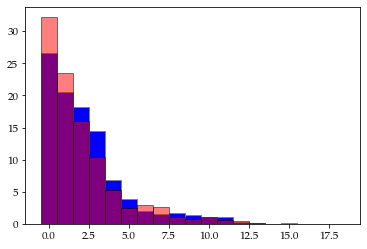

In [154]:
n=15
sizes = df_tmp["fz"]
max_s = sizes.max()
print(max_s)
max_s = (np.ceil((max_s/n)+1)*n).astype(int)
df_tmp['discrete'] = pd.cut(df_tmp["fz"], list(range(0, max_s, n)), include_lowest=True)
df_tmp["discrete"] = [int(x.right) for x in df_tmp["discrete"]]

hist = list(np.histogram(df_tmp["fz"][::2], bins=list(range(0, max_s, n)), density=True))

fig, ax = plt.subplots()
ax.bar(list(range(int(max_s/n)-1)), hist[0]*100*n, width=1, linewidth=1, edgecolor="grey", facecolor="blue", zorder=0)

results = "/Users/simongutwein/Desktop/segment_results.pkl"

df = pd.read_pickle(results)
df = pd.melt(df, id_vars=['segment', "fieldsize"], value_vars=['mixed', 'prostate'])
df["fieldsize"] = df["fieldsize"].astype(float)
df["value"] = df["value"].replace("\n", "").astype(float)

sizes = df["fieldsize"]
max_s = sizes.max()
max_s = (np.ceil((max_s/n)+1)*n).astype(int)
df['discrete'] = pd.cut(df["fieldsize"], list(range(0, max_s, n)), include_lowest=True)
df["discrete"] = [int(x.right) for x in df["discrete"]]

hist = list(np.histogram(df["fieldsize"][::2], bins=list(range(0, max_s, n)), density=True))

ax.bar(list(range(int(max_s/n)-1)), hist[0]*100*n, width=1, linewidth=1, edgecolor="black", facecolor="red", zorder=0, alpha=0.5)


In [173]:
strings = ["tensor(38.5729)\n", "tensor(145.29)\n"]

import re

for string in strings:
    print(string)
    x = np.array(re.findall(r"\d*\.\d*", string)).astype(float)
    print(x)


tensor(38.5729)

[38.5729]
tensor(145.29)

[145.29]


In [798]:
#print(-np.array([99.199.2, 75.4 - 89.8, 57.82-76.93,  60.48-80.13, 77.42-85.17]).round(2))  # segment mean
print(-np.array([99.1-99.2, 89.9-97.6, 67.4-83.6, 77.4 - 88.8, 93.0-96.0]).round(2))  # plan mean



[ 0.1  7.7 16.2 11.4  3. ]


Plan has 40 segments.
Plan has 91 segments.
Plan has 68 segments.
Plan has 99 segments.
Plan has 81 segments.
Plan has 57 segments.
Plan has 46 segments.
Plan has 58 segments.
Plan has 55 segments.
Plan has 56 segments.
Plan has 75 segments.
Plan has 77 segments.
Plan has 111 segments.
Plan has 77 segments.
Plan has 79 segments.
Plan has 28 segments.
Plan has 32 segments.
Plan has 30 segments.
Plan has 19 segments.
Plan has 49 segments.
Plan has 60 segments.
Plan has 19 segments.
Plan has 72 segments.
Plan has 67 segments.
Plan has 34 segments.
Plan has 51 segments.
Plan has 52 segments.
Plan has 59 segments.
Plan has 30 segments.
Plan has 57 segments.
Plan has 62 segments.
Plan has 62 segments.
Plan has 52 segments.
Plan has 68 segments.
Plan has 62 segments.


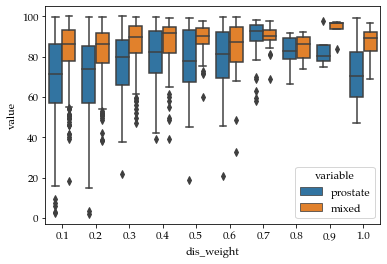

In [288]:
from pydicom import dcmread
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_cases"
plans = [x for x in os.listdir(root) if not x.startswith(".")]

weights = []
for plan in plans:

    pf = os.path.join(root, plan, [x for x in os.listdir(os.path.join(root, plan)) if not x.startswith(".") and "plan" in x][0])

    dicom_file = dcmread(pf, force=True)

    meterset_weights = []
    for beam in dicom_file.BeamSequence:
        for control_point in beam.ControlPointSequence:
            meterset_weights.append(float(control_point.CumulativeMetersetWeight))

    segment_weights = [meterset_weights[i] - meterset_weights[i-1] for i in range(1, len(meterset_weights), 2)]
    print(f"Plan has {len(segment_weights)} segments.")
    segment_names = [f"{plan}_{x}" for x in range(len(segment_weights))]

    weights.extend(zip(segment_weights, segment_names))

df_weight = pd.DataFrame(weights)
import seaborn as sb

results = "/Users/simongutwein/Desktop/segment_results.pkl"

df_fz = pd.read_pickle(results)

new_df = pd.merge(df_weight, df_fz, left_on=1, right_on="segment")
new_df = new_df.drop(columns=1)
new_df = new_df.rename(columns={0: 'weight'})
new_df["fieldsize"] = new_df["fieldsize"].astype(float)
new_df["mixed"] = new_df["mixed"].replace("\n", "").astype(float)
new_df["prostate"] = new_df["prostate"].replace("\n", "").astype(float)

bins = [(np.round(x,2), np.round(x+0.1,2)) for x in np.linspace(0,1,11)][:-1]

bins = pd.IntervalIndex.from_tuples(bins)
new_df["dis_weight"] = pd.cut(new_df["weight"], bins)
new_df["dis_weight"] = [float(x.right) for x in new_df["dis_weight"]]
new_df = pd.melt(new_df,id_vars=["weight", "segment", "fieldsize", "dis_weight"], value_vars=["prostate", "mixed"])

fig, ax = plt.subplots()
ax2 = sb.boxplot(x="dis_weight", y="value", hue="variable", data=new_df)



In [293]:
from pydicom import dcmread
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_cases"
plans = [x for x in os.listdir(root) if not x.startswith(".")]

weights = []
modu = []
for plan in plans:

    pf = os.path.join(root, plan, [x for x in os.listdir(os.path.join(root, plan)) if not x.startswith(".") and "plan" in x][0])

    dicom_file = dcmread(pf, force=True)

    meterset_weights = []
    for beam in dicom_file.BeamSequence:
        for control_point in beam.ControlPointSequence:
            meterset_weights.append(float(control_point.CumulativeMetersetWeight))

    segment_weights = [meterset_weights[i] - meterset_weights[i-1] for i in range(1, len(meterset_weights), 2)]
    #print(f"Plan has {len(segment_weights)} segments.")
    segment_names = [f"{plan}_{x}" for x in range(len(segment_weights))]

    weights.extend(zip(segment_weights, segment_names))

    modu.append({
        "plan": plan,
        "mod": len(segment_weights)
    })

df_weight = pd.DataFrame(weights)
df_modu = pd.DataFrame(modu)


,plan,mod
0,ht0,40
1,ht1,91
2,ht2,68
3,ht3,99
4,ht4,81
5,lt0,57
6,lt1,46
7,lt2,58
8,lt3,55
9,lt4,56


In [297]:
for name in ["pt", "ht", "mt", "lt"]:
    print(name, df_modu[df_modu["plan"].str.contains(name)]["mod"].mean(), df_modu[df_modu["plan"].str.contains(name)]["mod"].std())



pt 61.2 5.761944116355173
ht 75.8 23.12358103754693
mt 83.8 15.27088733505686
lt 54.4 4.827007354458868


In [60]:
root = "/Users/simongutwein/Studium/Masterarbeit/mamma"
plans = [x for x in os.listdir(root) if not x.startswith(".")]
plans

['mt0_6', 'mt0_55', 'mt2_16']

(512, 512, 109)
2.3627
[195 314  80]
(512, 512, 109)
1.8935
[210 367  36]
(512, 512, 115)
3.0733
[177 216  14]


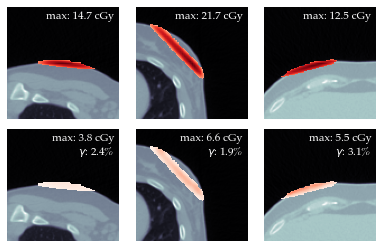

In [63]:
@latex(width=14, height=9, path="/Users/simongutwein/Desktop/mamma.pdf")
def test():

    fig, ax = plt.subplots(2,3)
    for num, plan in enumerate(plans):

        ct = np.array(torch.load(os.path.join(root, plan, "training_data.pt")))[1]
        print(ct.shape)
        path = os.path.join(root, plan, "prostate_trained_UNET_2234.pt")
        gamma = float(open(os.path.join(path, "gamma.txt")).readlines()[-5].strip())
        print(gamma)
        pred = np.array(torch.load(os.path.join(path, "prediction.pt")))
        target = np.array(torch.load(os.path.join(path, "target.pt")))

        idx = np.argwhere(target==target.max())[0]
        print(idx)

        pred[target < 1] = np.nan
        target[target < 1] = np.nan

        ax[0, num].imshow(ct[idx[0]-50:idx[0]+50, idx[1]-50:idx[1]+50, idx[2]], cmap="bone")
        ax[1, num].imshow(ct[idx[0]-50:idx[0]+50, idx[1]-50:idx[1]+50, idx[2]], cmap="bone")
        ax[0, num].imshow(target[idx[0]-50:idx[0]+50,idx[1]-50:idx[1]+50,idx[2]],vmin=0, vmax=np.nanmax(target),cmap="Reds")
        ax[1, num].imshow(pred[idx[0]-50:idx[0]+50, idx[1]-50:idx[1]+50, idx[2]], vmin=0, vmax=np.nanmax(target), cmap="Reds")
        
        t_max = str(np.round(np.nanmax(target)*5.881, 1))
        p_max = str(np.round(np.nanmax(pred)*5.881, 1))
        p_gamma = str(np.round(gamma, 1))

        ax[0, num].text(95, 10, f"max: {t_max} cGy", ha="right", color="white")
        ax[1, num].text(95, 10, f"max: {p_max} cGy", ha="right", color="white")
        ax[1, num].text(95, 22, r'$\gamma$: '+f"{p_gamma}%", ha="right", color="white")
        ax[0, num].axis("off")
        ax[1, num].axis("off")


    plt.tight_layout()
    return fig
test()


In [366]:
df = pd.read_pickle("/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_case_results.pkl")


In [372]:
df = df[df.model.str.contains("mixed")]
df

,plan,model,gamma,modulated,test_modularity
0,ht0,mixed_trained_UNET_1183.pt,96.2638,40,Mixed (2)
2,ht1,mixed_trained_UNET_1183.pt,92.7390,91,Mixed (2)
4,ht2,mixed_trained_UNET_1183.pt,79.6340,68,Mixed (2)
6,ht3,mixed_trained_UNET_1183.pt,92.9420,99,Mixed (2)
8,ht4,mixed_trained_UNET_1183.pt,91.8420,81,Mixed (2)
10,lt0,mixed_trained_UNET_1183.pt,89.5087,57,Mixed (2)
12,lt1,mixed_trained_UNET_1183.pt,100.0000,46,Mixed (2)
14,lt2,mixed_trained_UNET_1183.pt,98.5320,58,Mixed (2)
16,lt3,mixed_trained_UNET_1183.pt,99.9190,55,Mixed (2)
18,lt4,mixed_trained_UNET_1183.pt,99.9689,56,Mixed (2)


In [380]:
print(df[df.plan.str.contains("m")].modulated.mean(), "±", df[df.plan.str.contains("m")].modulated.std())


83.8 ± 15.27088733505686


In [385]:
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/training/training_mamma"
plans = pd.DataFrame({"seg":[x for x in os.listdir(root) if not x.startswith(".")]})


In [386]:
plans

,seg
0,m0_0
1,m0_1
2,m0_10
3,m0_11
4,m0_12
...,...
232,m9_5
233,m9_6
234,m9_7
235,m9_8


In [389]:
num = []
for i in range(10):
    num.append(len(plans[plans.seg.str.contains(f"m{i}")]))



In [391]:
num = np.array(num)

In [394]:
print(num.mean(), "±", num.std())

23.7 ± 5.568662316930341


In [ ]:
83.8 ± 15.27088733505686
23.7 ± 5.568662316930341


In [568]:
from tqdm import tqdm
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/plan_predictions_load/"
files = [x for x in os.listdir(root) if not x.startswith(".")]

dat = []
for file in tqdm(files):
    mix_new = root + file + "/mixed_trained_UNET_1183.pt/gamma.txt"
    pros_new = root + file + "/prostate_trained_UNET_2234.pt/gamma.txt"
    dat.append({
        "test_case":file,
        "mixed_gamma": float(open(mix_new).readlines()[4].strip()),
        "prostate_gamma": float(open(pros_new).readlines()[4].strip())
    })
    
print(dat)


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]

[{'test_case': 'ht0', 'mixed_gamma': 98.5, 'prostate_gamma': 90.24}, {'test_case': 'ht1', 'mixed_gamma': 93.205, 'prostate_gamma': 78.84}, {'test_case': 'ht2', 'mixed_gamma': 75.97, 'prostate_gamma': 62.48}, {'test_case': 'ht3', 'mixed_gamma': 90.94, 'prostate_gamma': 81.565}, {'test_case': 'ht4', 'mixed_gamma': 85.35, 'prostate_gamma': 73.965}, {'test_case': 'lt0', 'mixed_gamma': 97.42, 'prostate_gamma': 87.39}, {'test_case': 'lt1', 'mixed_gamma': 99.22, 'prostate_gamma': 94.395}, {'test_case': 'lt2', 'mixed_gamma': 97.98, 'prostate_gamma': 91.8}, {'test_case': 'lt3', 'mixed_gamma': 96.55, 'prostate_gamma': 83.97}, {'test_case': 'lt4', 'mixed_gamma': 96.95, 'prostate_gamma': 91.755}, {'test_case': 'mt0', 'mixed_gamma': 83.675, 'prostate_gamma': 72.95}, {'test_case': 'mt1', 'mixed_gamma': 77.03, 'prostate_gamma': 60.55}, {'test_case': 'mt2', 'mixed_gamma': 84.71, 'prostate_gamma': 66.21}, {'test_case': 'mt3', 'mixed_gamma': 89.785, 'prostate_gamma': 72.58}, {'test_case': 'mt4', 'mixed_

In [573]:
df = pd.DataFrame(dat)
df['test_case'] = df['test_case'].str.replace('\d+', '')
df


/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_1349/780464707.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['test_case'] = df['test_case'].str.replace('\d+', '')


,test_case,mixed_gamma,prostate_gamma
0,ht,98.500,90.240
1,ht,93.205,78.840
2,ht,75.970,62.480
3,ht,90.940,81.565
4,ht,85.350,73.965
5,lt,97.420,87.390
6,lt,99.220,94.395
7,lt,97.980,91.800
8,lt,96.550,83.970
9,lt,96.950,91.755


In [574]:
ent = ["pt", "ht", "lt", "mt", "nt"]
test = ["Prostate", "Mixed", "Mixed", "Mixed", "Lymphnodes"]
long = ["Prostate", "H&N", "Liver", "Mamma", "Lymphnodes"]
df_ent = pd.DataFrame({"entity": ent, "test": test, "long":long})

df['test_case'] = df['test_case'].map(df_ent.set_index('entity')['long'])
df


,test_case,mixed_gamma,prostate_gamma
0,H&N,98.500,90.240
1,H&N,93.205,78.840
2,H&N,75.970,62.480
3,H&N,90.940,81.565
4,H&N,85.350,73.965
5,Liver,97.420,87.390
6,Liver,99.220,94.395
7,Liver,97.980,91.800
8,Liver,96.550,83.970
9,Liver,96.950,91.755


In [575]:
df['test_mode'] = None
df['test_mode'] = df['test_case'].map(df_ent.set_index('long')['test'])
df


,test_case,mixed_gamma,prostate_gamma,test_mode
0,H&N,98.500,90.240,Mixed
1,H&N,93.205,78.840,Mixed
2,H&N,75.970,62.480,Mixed
3,H&N,90.940,81.565,Mixed
4,H&N,85.350,73.965,Mixed
5,Liver,97.420,87.390,Mixed
6,Liver,99.220,94.395,Mixed
7,Liver,97.980,91.800,Mixed
8,Liver,96.550,83.970,Mixed
9,Liver,96.950,91.755,Mixed


In [576]:
res = []
for t in long:
    mini = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].min(),1)
    maxi = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].max(),1)
    mean = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].mean(),1)
    std = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].std(),1)
    median = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].median(),1)
    mini2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].min(), 1)
    maxi2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].max(), 1)
    mean2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].mean(), 1)
    std2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].std(), 1)
    median2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].median(), 1)
    res.append({
        "test": t,
        "Model": "Prostate",
        "Mean": mean2,
        "Median": median2,
        "STD": std2,
        "Min": mini2,
        "Max": maxi2
    })
    res.append({
        "test": t,
        "Model": "Mixed",
        "Mean":mean,
        "Median":median,
        "STD": std,
        "Min":mini, 
        "Max": maxi
    })

df_res = pd.DataFrame(res)
df_res = df_res.T
df_res = df_res[[0, 1, 4, 5, 6, 7, 2, 3, 8, 9]]
df_res


,0,1,4,5,6,7,2,3,8,9
test,Prostate,Prostate,Liver,Liver,Mamma,Mamma,H&N,H&N,Lymphnodes,Lymphnodes
Model,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed
Mean,99.1,99.2,89.9,97.6,67.4,83.6,77.4,88.8,93.0,96.0
Median,99.6,99.7,91.8,97.4,66.2,83.7,78.8,90.9,92.8,98.8
STD,1.3,1.0,4.1,1.0,5.3,4.6,10.2,8.6,6.1,5.8
Min,96.8,97.5,84.0,96.6,60.6,77.0,62.5,76.0,75.3,77.9
Max,99.9,99.9,94.4,99.2,73.0,89.8,90.2,98.5,99.7,99.9


In [558]:
from tqdm import tqdm
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/segment_results/"
files = [x for x in os.listdir(root) if not x.startswith(".")]

dat = []
for num, file in enumerate(files):
    print(num)
    segs = [x for x in os.listdir(root + file) if not x.startswith(".")]
    for seg in tqdm(segs):
        mix_new = root + file + "/" + seg + "/mixed_trained_UNET_1183.pt/gamma.txt"
        pros_new = root + file + "/" + seg + "/prostate_trained_UNET_2234.pt/gamma.txt"
        dat.append({
        "test_case": file,
        "mixed_gamma": float(open(mix_new).readlines()[4].strip()),
        "prostate_gamma": float(open(pros_new).readlines()[4].strip())
        })

print(dat)


0


100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


1


100%|██████████| 91/91 [01:58<00:00,  1.30s/it]


2


100%|██████████| 68/68 [01:31<00:00,  1.35s/it]


3


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


4


100%|██████████| 81/81 [01:15<00:00,  1.08it/s]


5


100%|██████████| 57/57 [01:00<00:00,  1.07s/it]


6


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]


7


100%|██████████| 58/58 [00:46<00:00,  1.24it/s]


8


100%|██████████| 55/55 [00:36<00:00,  1.49it/s]


9


100%|██████████| 56/56 [00:37<00:00,  1.51it/s]


10


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


11


100%|██████████| 77/77 [00:44<00:00,  1.72it/s]


12


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


13


100%|██████████| 77/77 [00:51<00:00,  1.49it/s]


14


100%|██████████| 79/79 [00:55<00:00,  1.43it/s]


15


100%|██████████| 28/28 [00:15<00:00,  1.75it/s]


16


100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


17


  0%|          | 0/19 [00:00<?, ?it/s]

18


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


19


100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


20


100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


21


100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


22


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


23


100%|██████████| 67/67 [00:50<00:00,  1.33it/s]


24


100%|██████████| 34/34 [00:19<00:00,  1.76it/s]


25


100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


26


100%|██████████| 52/52 [00:31<00:00,  1.67it/s]


27


100%|██████████| 59/59 [00:31<00:00,  1.86it/s]


28


100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


29


100%|██████████| 57/57 [00:41<00:00,  1.38it/s]


30


100%|██████████| 62/62 [00:46<00:00,  1.32it/s]


31


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


32


  0%|          | 0/68 [00:00<?, ?it/s]

33


100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


34


100%|██████████| 62/62 [00:42<00:00,  1.44it/s]

[{'test_case': 'ht0', 'mixed_gamma': 84.875, 'prostate_gamma': 73.415}, {'test_case': 'ht0', 'mixed_gamma': 78.485, 'prostate_gamma': 70.785}, {'test_case': 'ht0', 'mixed_gamma': 84.755, 'prostate_gamma': 80.485}, {'test_case': 'ht0', 'mixed_gamma': 88.795, 'prostate_gamma': 82.55}, {'test_case': 'ht0', 'mixed_gamma': 89.39, 'prostate_gamma': 65.77}, {'test_case': 'ht0', 'mixed_gamma': 92.1, 'prostate_gamma': 62.815}, {'test_case': 'ht0', 'mixed_gamma': 95.77, 'prostate_gamma': 68.63}, {'test_case': 'ht0', 'mixed_gamma': 93.31, 'prostate_gamma': 86.5}, {'test_case': 'ht0', 'mixed_gamma': 94.84, 'prostate_gamma': 86.05}, {'test_case': 'ht0', 'mixed_gamma': 96.73, 'prostate_gamma': 91.485}, {'test_case': 'ht0', 'mixed_gamma': 91.74, 'prostate_gamma': 56.515}, {'test_case': 'ht0', 'mixed_gamma': 91.52, 'prostate_gamma': 73.745}, {'test_case': 'ht0', 'mixed_gamma': 87.04, 'prostate_gamma': 79.965}, {'test_case': 'ht0', 'mixed_gamma': 92.685, 'prostate_gamma': 78.63}, {'test_case': 'ht0', '

In [565]:
df = pd.DataFrame(dat)
df['test_case'] = df['test_case'].str.replace('\d+', '')
ent = ["pt", "ht", "lt", "mt", "nt"]
test = ["Prostate", "Mixed", "Mixed", "Mixed", "Lymphnodes"]
long = ["Prostate", "H&N", "Liver", "Mamma", "Lymphnodes"]
df_ent = pd.DataFrame({"entity": ent, "test": test, "long": long})

df['test_case'] = df['test_case'].map(df_ent.set_index('entity')['long'])
df['test_mode'] = None
df['test_mode'] = df['test_case'].map(df_ent.set_index('long')['test'])

res = []
for t in long:
    mini = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].min(), 1)
    maxi = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].max(), 1)
    mean = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].mean(), 1)
    std = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].std(), 1)
    median = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].median(), 1)
    mini2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].min(), 1)
    maxi2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].max(), 1)
    mean2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].mean(), 1)
    std2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].std(), 1)
    median2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].median(), 1)
    res.append({
        "test": t,
        "Model": "Prostate",
        "Mean": mean2,
        "Median": median2,
        "STD": std2,
        "Min": mini2,
        "Max": maxi2
    })
    res.append({
        "test": t,
        "Model": "Mixed",
        "Mean": mean,
        "Median": median,
        "STD": std,
        "Min": mini,
        "Max": maxi
    })

df_res = pd.DataFrame(res)
df_res = df_res.T
df_res = df_res[[0, 1, 4, 5, 6, 7, 2,3,8,9]]
df_res


/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_1349/1290184849.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['test_case'] = df['test_case'].str.replace('\d+', '')


,0,1,4,5,6,7,2,3,8,9
test,Prostate,Prostate,Liver,Liver,Mamma,Mamma,H&N,H&N,Lymphnodes,Lymphnodes
Model,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed
Mean,94.3,93.5,75.4,89.8,57.8,76.9,60.5,80.1,77.4,85.2
Median,96.2,95.0,77.4,91.6,56.4,78.9,61.0,82.8,80.2,87.8
STD,6.0,6.3,12.6,7.0,18.0,12.8,11.8,10.9,13.8,10.7
Min,58.0,39.2,38.9,50.8,1.9,18.4,31.1,49.3,36.0,38.7
Max,100.0,99.8,99.4,99.1,94.7,98.5,91.5,97.4,99.7,99.9


In [6]:
patient = "pt0"

root_dir = "/Users/simongutwein/Studium/Masterarbeit/preds/" + patient

target_dose = np.array(torch.load(os.path.join(root_dir, f"mixed_trained_UNET_1183.pt/target.pt")))
    
print(target_dose.shape)

ct_file = os.path.join(root_dir, "cts/CT_image0.dcm")

with dcmread(ct_file, force=True) as fin:
    origin = np.array(fin.ImagePositionPatient).astype(float)
    px_sp = fin.PixelSpacing
    px_sp.append(3)
    px_sp = np.array(px_sp).astype(float)
    print(origin, px_sp)

structure_file = os.path.join(root_dir, f"{patient}_strctr.dcm")
        


(512, 512, 125)
[-300.  -267.8 -390.9] [1.171875 1.171875 3.      ]


In [7]:
from itertools import zip_longest
def read_structures(strucure_file_path: str, image_origin: list, px_sp: list) -> dict:

    image_origin = np.array(image_origin)
    px_sp = np.array(px_sp)

    structures = []
    structures_data = []
    with dcmread(strucure_file_path, force=True) as dcm_in:
        for struc in dcm_in.StructureSetROISequence:
            structures.append({
                "struc_name": struc.ROIName,
                "struc_number": struc.ROINumber
            })

        for struc in dcm_in.ROIContourSequence:
            contour_data = []
            for data in struc.ContourSequence:
                contour_data.append(((np.array(data.ContourData).reshape((-1, 3))-image_origin)/px_sp).astype(int))
            structures_data.append({
                "struc_number": struc.ReferencedROINumber,
                "contour_data": contour_data
            })

    struc_data = [{**u, **v} for u, v in zip_longest(structures, structures_data, fillvalue={})]
    return struc_data


In [8]:
strucs = read_structures(structure_file, origin, px_sp)

In [9]:
def create_binary(structure_data: dict, volume_shape: list) -> dict:

    for struc in structure_data:
        if not "z" in struc["struc_name"].lower():
            binary = np.zeros(volume_shape)
            for slice_ in struc["contour_data"]:
                poly = slice_[:, :2]
                img = binary[:, :, slice_[0, 2]].copy()
                #binary[:, :, slice_[0, 2]] = cv2.fillPoly(img=img, pts=np.int32([poly]), color=1)
                binary[:, :, slice_[0, 2]] = cv2.drawContours(img, np.int32([poly]), -1, color=1, thickness=cv2.FILLED)
            struc["binary_mask"] = binary.astype(bool)
            print(binary.shape)

    return structure_data


In [10]:
import cv2
strucs = create_binary(strucs, target_dose.shape)


(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)


In [11]:
df = pd.DataFrame(strucs)

In [12]:
needed = ["patient", "Bladder", "Femur_R",  "Rectum","Femur_L" ,"PTV"]

n_df = df[df['struc_name'].isin(needed)]
n_df.struc_name
print(n_df.keys())

Index(['struc_name', 'struc_number', 'contour_data', 'binary_mask'], dtype='object')


(512, 512, 125)
(512, 512, 125)
185 365
96 399
1.6094445


/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_3560/2782038097.py:48: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(im, cax=cax, orientation='vertical', boundaries=[0,5,10,15])
/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_3560/2782038097.py:55: UserWarning: No contour levels were found within the data range.
  ax.contour(mask2[begin-5:end+5, begin2-5:end2+5, layer], levels=[0,2], cmap="Greys", zorder=10)
/usr/local/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
/usr/local/lib/python3.9/site-packages/matplotl

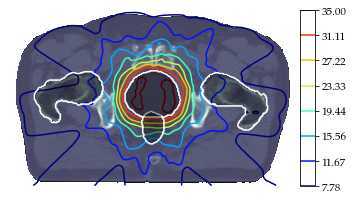

In [15]:
@latex(width=14, height=9, path="/Users/simongutwein/Desktop/example_image.pdf")
def func():

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, ax = plt.subplots(1,1)
    import torch
    layer = 50
    mask = n_df[n_df["struc_name"] == "patient"]["binary_mask"][0]
    print(mask.shape)

    begin = False
    end = False
    for n, i in enumerate(mask[:,:,layer]):
        if np.any(i) and begin is False:
            begin = n
        elif not np.any(i) and begin is not False and end is False:
            end = n

    begin2 = False
    end2 = False
    tmp = np.moveaxis(mask, 0,1)
    print(tmp.shape)
    for n, i in enumerate(tmp[:, :, layer]):
        if np.any(i) and begin2 is False:
            begin2 = n
        elif not np.any(i) and begin2 is not False and end2 is False:
            end2 = n


    begin2 = begin2 -5

    end2 = end2 +5
    print(begin, end)
    print(begin2, end2)

    ct = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/training_data.pt"))[1]
    print(ct.max())
    target = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/target.pt"))
    #target[ct < .15] = np.nan
    ct[ct<.15] = np.nan

    ax.imshow(ct[begin-5:end+5,begin2-5:end2+5,layer], cmap="bone", zorder=-1)
    #ax.imshow(target[begin-5:end+5, begin2-5:end2+5, layer], cmap="jet", alpha=.5)
    im = ax.contour(target[begin-5:end+5, begin2-5:end2+5, layer], levels=np.linspace(0, 35, 10)[2:], cmap="jet", zorder=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    
    cmaps = ['Greys', 'Purples', 'Blues', 'Reds', 'Oranges','Greens']
    for num ,struc in enumerate(n_df.iterrows()):
        if not struc[1]["struc_name"] == "patient":
            mask2 = struc[1]["binary_mask"].astype(float)
            ax.contour(mask2[begin-5:end+5, begin2-5:end2+5, layer], levels=[0,2], cmap="Greys", zorder=10)
            mask2[mask2<0.9] = np.nan
            ax.imshow(mask2[begin-5:end+5, begin2-5:end2+5, layer], cmap="gray", alpha=0.4, zorder=10)
    ax.axis("off")
    
    return fig

func()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from tqdm import tqdm

In [15]:
def create_gif(images_dir: str, save_dir: str) -> None:
    '''
    creates a gif from a folder with respective images in it

    Parameters:
    image_dir:  directory with the images for the gif in it
    save_dir:   directory where the created .gif is saved
    '''
    images = [os.path.join(images_dir, x) for x in os.listdir(images_dir) if not x.startswith(".")]
    images = natsorted(images)

    imgs = []
    for path in images:
        imgs.append(Image.open(path))

    imgs[0].save(
        os.path.join(save_dir, "pca.gif"),
        save_all=True,
        append_images=imgs[1:],
        optimize=False,
        duration=40,
        loop=1
    )

In [13]:
n = 20
low = 10
high = 190
positions = np.stack((np.random.randint(low=low, high=high, size=n), np.random.randint(low=low, high=high, size=n),
                      np.random.randint(low=low, high=high, size=n), np.random.randint(low=10, high=30, size=n)))

print(positions.T)


for a in tqdm(range(0,360,1)):

    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25., azim=a)

    colors = [
        "black",
        "red",
        "green",
        "orange",
        "blue",
        "black",
        "red",
        "green",
        "orange",
        "blue",
        "black",
        "red"
    ]

    for pos, color in zip(positions.T, colors):
        
        u = np.linspace(0, 2 * np.pi, 50)
        v = np.linspace(0, np.pi, 50)
        x = np.outer(np.cos(u) * np.sqrt(pos[3]), np.sin(v) * np.sqrt(pos[3])) + pos[0]
        y = np.outer(np.sin(u) * np.sqrt(pos[3]), np.sin(v) * np.sqrt(pos[3]))+ pos[1]
        z = np.outer(np.ones(np.size(u)) * np.sqrt(pos[3]), np.cos(v) * np.sqrt(pos[3])) + pos[2]

        ax.plot_surface(x, y, z, linewidth=1, color=color)


    ax.plot([0, 0], [0, 200], [0, 0], '--r', alpha=0.5)
    ax.plot([0, 200], [0, 0], [0, 0], '--r', alpha=0.5)
    ax.plot([0, 0], [0, 0], [0, 200], '--r', alpha=0.5)

    ax.plot([200, 0], [200, 200], [200, 200], '--r', alpha=0.5)
    ax.plot([200, 200], [200, 0], [200, 200], '--r', alpha=0.5)
    ax.plot([200, 200], [200, 200], [200, 0], '--r', alpha=0.5)

    ax.plot([200, 0], [200, 200], [0, 0], '--r', alpha=0.5)
    ax.plot([0, 0], [200, 200], [0, 200], '--r', alpha=0.5)
    ax.plot([0, 0], [200, 0], [200, 200], '--r', alpha=0.5)

    ax.plot([200, 0], [0, 0], [200, 200], '--r', alpha=0.5)
    ax.plot([200, 200], [0, 0], [0, 200], '--r', alpha=0.5)
    ax.plot([200, 200], [200, 0], [0, 0], '--r', alpha=0.5)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.axis("off")
    plt.savefig(f"/Users/simongutwein/Desktop/artificial/{a}.png")
    plt.close()


  0%|          | 0/360 [00:00<?, ?it/s]

[[ 34  56 129  20]
 [ 29  65  62  20]
 [ 42  53  85  15]
 [ 90  89  62  25]
 [ 68  74 130  28]
 [165 103 175  29]
 [108 132 140  22]
 [ 67 122  26  18]
 [189  12  26  12]
 [128  86 189  26]
 [177 108  87  17]
 [ 88 103  41  19]
 [ 79 141 164  15]
 [ 26  40 181  11]
 [ 37  86  66  22]
 [129 183 100  17]
 [158  54 150  18]
 [ 50 135 185  11]
 [145  94 102  11]
 [ 83 114 101  16]]
0


  0%|          | 1/360 [00:02<12:55,  2.16s/it]

1


  1%|          | 2/360 [00:04<12:29,  2.09s/it]

2


  1%|          | 3/360 [00:06<12:03,  2.03s/it]

3


  1%|          | 4/360 [00:14<26:33,  4.48s/it]

4


  1%|▏         | 5/360 [00:16<21:04,  3.56s/it]

5


  2%|▏         | 6/360 [00:18<17:55,  3.04s/it]

6


  2%|▏         | 7/360 [00:20<15:42,  2.67s/it]

7


  2%|▏         | 8/360 [00:22<14:21,  2.45s/it]

8


  2%|▎         | 9/360 [00:24<13:35,  2.32s/it]

9


  3%|▎         | 10/360 [00:26<12:45,  2.19s/it]

10


  3%|▎         | 11/360 [00:28<12:29,  2.15s/it]

11


  3%|▎         | 12/360 [00:30<12:19,  2.13s/it]

12


  4%|▎         | 13/360 [00:32<11:52,  2.05s/it]

13


  4%|▍         | 14/360 [00:34<11:39,  2.02s/it]

14


  4%|▍         | 15/360 [00:36<11:42,  2.04s/it]

15


  4%|▍         | 16/360 [00:38<11:25,  1.99s/it]

16


  5%|▍         | 17/360 [00:40<11:38,  2.04s/it]

17


  5%|▌         | 18/360 [00:42<11:26,  2.01s/it]

18


  5%|▌         | 19/360 [00:44<11:27,  2.02s/it]

19


  6%|▌         | 20/360 [00:46<11:31,  2.03s/it]

20


  6%|▌         | 21/360 [00:48<11:18,  2.00s/it]

21


  6%|▌         | 22/360 [00:50<11:15,  2.00s/it]

22


  6%|▋         | 23/360 [00:52<11:28,  2.04s/it]

23


  7%|▋         | 24/360 [00:54<11:13,  2.00s/it]

24


  7%|▋         | 25/360 [00:56<11:03,  1.98s/it]

25


  7%|▋         | 26/360 [00:58<10:55,  1.96s/it]

26


  8%|▊         | 27/360 [01:00<11:11,  2.02s/it]

27


  8%|▊         | 28/360 [01:02<11:05,  2.01s/it]

28


  8%|▊         | 29/360 [01:04<10:56,  1.98s/it]

29


  8%|▊         | 30/360 [01:06<10:52,  1.98s/it]

30


  9%|▊         | 31/360 [01:08<11:04,  2.02s/it]

31


  9%|▉         | 32/360 [01:10<10:59,  2.01s/it]

32


  9%|▉         | 33/360 [01:12<10:57,  2.01s/it]

33


  9%|▉         | 34/360 [01:14<10:48,  1.99s/it]

34


 10%|▉         | 35/360 [01:16<10:45,  1.98s/it]

35


 10%|█         | 36/360 [01:18<11:03,  2.05s/it]

36


 10%|█         | 37/360 [01:20<10:56,  2.03s/it]

37


 11%|█         | 38/360 [01:22<10:44,  2.00s/it]

38


 11%|█         | 39/360 [01:24<11:15,  2.10s/it]

39


 11%|█         | 40/360 [01:26<11:05,  2.08s/it]

40


 11%|█▏        | 41/360 [01:28<10:53,  2.05s/it]

41


 12%|█▏        | 42/360 [01:31<11:28,  2.16s/it]

42


 12%|█▏        | 43/360 [01:32<11:02,  2.09s/it]

43


 12%|█▏        | 44/360 [01:34<10:51,  2.06s/it]

44


 12%|█▎        | 45/360 [01:36<10:35,  2.02s/it]

45


 13%|█▎        | 46/360 [01:39<10:51,  2.07s/it]

46


 13%|█▎        | 47/360 [01:41<10:35,  2.03s/it]

47


 13%|█▎        | 48/360 [01:42<10:24,  2.00s/it]

48


 14%|█▎        | 49/360 [01:45<10:58,  2.12s/it]

49


 14%|█▍        | 50/360 [01:47<10:42,  2.07s/it]

50


 14%|█▍        | 51/360 [01:49<10:34,  2.05s/it]

51


 14%|█▍        | 52/360 [01:51<10:27,  2.04s/it]

52


 15%|█▍        | 53/360 [01:53<10:18,  2.02s/it]

53


 15%|█▌        | 54/360 [01:55<10:17,  2.02s/it]

54


 15%|█▌        | 55/360 [01:57<10:07,  1.99s/it]

55


 16%|█▌        | 56/360 [01:59<10:11,  2.01s/it]

56


 16%|█▌        | 57/360 [02:01<10:46,  2.14s/it]

57


 16%|█▌        | 58/360 [02:03<10:24,  2.07s/it]

58


 16%|█▋        | 59/360 [02:05<10:18,  2.06s/it]

59


 17%|█▋        | 60/360 [02:07<10:03,  2.01s/it]

60


 17%|█▋        | 61/360 [02:09<10:02,  2.01s/it]

61


 17%|█▋        | 62/360 [02:11<09:53,  1.99s/it]

62


 18%|█▊        | 63/360 [02:13<09:48,  1.98s/it]

63


 18%|█▊        | 64/360 [02:15<09:46,  1.98s/it]

64


 18%|█▊        | 65/360 [02:17<10:23,  2.11s/it]

65


 18%|█▊        | 66/360 [02:19<10:07,  2.07s/it]

66


 19%|█▊        | 67/360 [02:21<09:59,  2.05s/it]

67


 19%|█▉        | 68/360 [02:23<09:48,  2.01s/it]

68


 19%|█▉        | 69/360 [02:25<09:45,  2.01s/it]

69


 19%|█▉        | 70/360 [02:27<09:33,  1.98s/it]

70


 20%|█▉        | 71/360 [02:29<09:36,  1.99s/it]

71


 20%|██        | 72/360 [02:31<09:29,  1.98s/it]

72


 20%|██        | 73/360 [02:33<09:25,  1.97s/it]

73


 21%|██        | 74/360 [02:35<09:27,  1.98s/it]

74


 21%|██        | 75/360 [02:38<10:21,  2.18s/it]

75


 21%|██        | 76/360 [02:40<10:04,  2.13s/it]

76


 21%|██▏       | 77/360 [02:42<09:41,  2.06s/it]

77


 22%|██▏       | 78/360 [02:44<09:35,  2.04s/it]

78


 22%|██▏       | 79/360 [02:46<09:22,  2.00s/it]

79


 22%|██▏       | 80/360 [02:47<09:13,  1.98s/it]

80


 22%|██▎       | 81/360 [02:49<09:12,  1.98s/it]

81


 23%|██▎       | 82/360 [02:51<09:05,  1.96s/it]

82


 23%|██▎       | 83/360 [02:53<09:12,  1.99s/it]

83


 23%|██▎       | 84/360 [02:55<09:04,  1.97s/it]

84


 24%|██▎       | 85/360 [02:57<09:01,  1.97s/it]

85


 24%|██▍       | 86/360 [02:59<09:03,  1.98s/it]

86


 24%|██▍       | 87/360 [03:02<09:48,  2.15s/it]

87


 24%|██▍       | 88/360 [03:04<09:27,  2.09s/it]

88


 25%|██▍       | 89/360 [03:06<09:13,  2.04s/it]

89


 25%|██▌       | 90/360 [03:08<09:02,  2.01s/it]

90


 25%|██▌       | 91/360 [03:10<09:00,  2.01s/it]

91


 26%|██▌       | 92/360 [03:12<08:50,  1.98s/it]

92


 26%|██▌       | 93/360 [03:14<08:52,  1.99s/it]

93


 26%|██▌       | 94/360 [03:16<08:43,  1.97s/it]

94


 26%|██▋       | 95/360 [03:18<08:44,  1.98s/it]

95


 27%|██▋       | 96/360 [03:20<08:48,  2.00s/it]

96


 27%|██▋       | 97/360 [03:22<08:45,  2.00s/it]

97


 27%|██▋       | 98/360 [03:24<08:47,  2.01s/it]

98


 28%|██▊       | 99/360 [03:26<08:39,  1.99s/it]

99


 28%|██▊       | 100/360 [03:28<08:31,  1.97s/it]

100


 28%|██▊       | 101/360 [03:30<09:45,  2.26s/it]

101


 28%|██▊       | 102/360 [03:32<09:20,  2.17s/it]

102


 29%|██▊       | 103/360 [03:34<08:57,  2.09s/it]

103


 29%|██▉       | 104/360 [03:36<08:46,  2.06s/it]

104


 29%|██▉       | 105/360 [03:38<08:33,  2.01s/it]

105


 29%|██▉       | 106/360 [03:40<08:31,  2.01s/it]

106


 30%|██▉       | 107/360 [03:42<08:21,  1.98s/it]

107


 30%|███       | 108/360 [03:44<08:20,  1.98s/it]

108


 30%|███       | 109/360 [03:46<08:13,  1.97s/it]

109


 31%|███       | 110/360 [03:48<08:22,  2.01s/it]

110


 31%|███       | 111/360 [03:50<08:22,  2.02s/it]

111


 31%|███       | 112/360 [03:52<08:17,  2.01s/it]

112


 31%|███▏      | 113/360 [03:54<08:13,  2.00s/it]

113


 32%|███▏      | 114/360 [03:56<08:07,  1.98s/it]

114


 32%|███▏      | 115/360 [03:58<08:02,  1.97s/it]

115


 32%|███▏      | 116/360 [04:01<09:33,  2.35s/it]

116


 32%|███▎      | 117/360 [04:03<09:02,  2.23s/it]

117


 33%|███▎      | 118/360 [04:06<09:03,  2.25s/it]

118


 33%|███▎      | 119/360 [04:08<09:04,  2.26s/it]

119


 33%|███▎      | 120/360 [04:10<08:44,  2.19s/it]

120


 34%|███▎      | 121/360 [04:12<08:29,  2.13s/it]

121


 34%|███▍      | 122/360 [04:14<09:01,  2.27s/it]

122


 34%|███▍      | 123/360 [04:17<08:44,  2.21s/it]

123


 34%|███▍      | 124/360 [04:19<08:54,  2.26s/it]

124


 35%|███▍      | 125/360 [04:21<08:35,  2.19s/it]

125


 35%|███▌      | 126/360 [04:23<08:23,  2.15s/it]

126


 35%|███▌      | 127/360 [04:25<08:45,  2.25s/it]

127


 36%|███▌      | 128/360 [04:28<08:34,  2.22s/it]

128


 36%|███▌      | 129/360 [04:30<08:30,  2.21s/it]

129


 36%|███▌      | 130/360 [04:32<08:15,  2.15s/it]

130


 36%|███▋      | 131/360 [04:34<08:04,  2.11s/it]

131


 37%|███▋      | 132/360 [04:36<07:51,  2.07s/it]

132


 37%|███▋      | 133/360 [04:38<07:41,  2.03s/it]

133


 37%|███▋      | 134/360 [04:42<10:35,  2.81s/it]

134


 38%|███▊      | 135/360 [04:44<09:37,  2.57s/it]

135


 38%|███▊      | 136/360 [04:46<08:53,  2.38s/it]

136


 38%|███▊      | 137/360 [04:48<08:22,  2.25s/it]

137


 38%|███▊      | 138/360 [04:50<08:03,  2.18s/it]

138


 39%|███▊      | 139/360 [04:52<07:45,  2.11s/it]

139


 39%|███▉      | 140/360 [04:54<07:37,  2.08s/it]

140


 39%|███▉      | 141/360 [04:56<07:23,  2.02s/it]

141


 39%|███▉      | 142/360 [04:58<07:41,  2.12s/it]

142


 40%|███▉      | 143/360 [05:01<07:35,  2.10s/it]

143


 40%|████      | 144/360 [05:03<07:33,  2.10s/it]

144


 40%|████      | 145/360 [05:05<07:27,  2.08s/it]

145


 41%|████      | 146/360 [05:07<07:21,  2.06s/it]

146


 41%|████      | 147/360 [05:09<07:22,  2.08s/it]

147


 41%|████      | 148/360 [05:11<07:22,  2.09s/it]

148


 41%|████▏     | 149/360 [05:13<07:12,  2.05s/it]

149


 42%|████▏     | 150/360 [05:15<07:12,  2.06s/it]

150


 42%|████▏     | 151/360 [05:17<07:08,  2.05s/it]

151


 42%|████▏     | 152/360 [05:19<07:17,  2.10s/it]

152


 42%|████▎     | 153/360 [05:21<07:09,  2.08s/it]

153


 43%|████▎     | 154/360 [05:23<07:05,  2.07s/it]

154


 43%|████▎     | 155/360 [05:28<09:28,  2.77s/it]

155


 43%|████▎     | 156/360 [05:30<08:58,  2.64s/it]

156


 44%|████▎     | 157/360 [05:32<08:17,  2.45s/it]

157


 44%|████▍     | 158/360 [05:34<07:47,  2.32s/it]

158


 44%|████▍     | 159/360 [05:36<07:29,  2.24s/it]

159


 44%|████▍     | 160/360 [05:38<07:16,  2.18s/it]

160


 45%|████▍     | 161/360 [05:40<07:05,  2.14s/it]

161


 45%|████▌     | 162/360 [05:42<07:00,  2.12s/it]

162


 45%|████▌     | 163/360 [05:45<07:26,  2.27s/it]

163


 46%|████▌     | 164/360 [05:47<07:10,  2.20s/it]

164


 46%|████▌     | 165/360 [05:49<06:56,  2.13s/it]

165


 46%|████▌     | 166/360 [05:51<06:49,  2.11s/it]

166


 46%|████▋     | 167/360 [05:53<06:38,  2.07s/it]

167


 47%|████▋     | 168/360 [05:55<06:29,  2.03s/it]

168


 47%|████▋     | 169/360 [05:57<06:21,  2.00s/it]

169


 47%|████▋     | 170/360 [05:59<06:22,  2.01s/it]

170


 48%|████▊     | 171/360 [06:01<06:14,  1.98s/it]

171


 48%|████▊     | 172/360 [06:03<06:12,  1.98s/it]

172


 48%|████▊     | 173/360 [06:05<06:10,  1.98s/it]

173


 48%|████▊     | 174/360 [06:07<06:05,  1.97s/it]

174


 49%|████▊     | 175/360 [06:09<06:17,  2.04s/it]

175


 49%|████▉     | 176/360 [06:11<06:13,  2.03s/it]

176


 49%|████▉     | 177/360 [06:13<06:12,  2.04s/it]

177


 49%|████▉     | 178/360 [06:15<06:36,  2.18s/it]

178


 50%|████▉     | 179/360 [06:21<09:13,  3.06s/it]

179


 50%|█████     | 180/360 [06:23<08:33,  2.85s/it]

180


 50%|█████     | 181/360 [06:25<07:51,  2.63s/it]

181


 51%|█████     | 182/360 [06:27<07:20,  2.48s/it]

182


 51%|█████     | 183/360 [06:29<07:01,  2.38s/it]

183


 51%|█████     | 184/360 [06:31<06:39,  2.27s/it]

184


 51%|█████▏    | 185/360 [06:33<06:23,  2.19s/it]

185


 52%|█████▏    | 186/360 [06:35<06:15,  2.16s/it]

186


 52%|█████▏    | 187/360 [06:37<06:07,  2.13s/it]

187


 52%|█████▏    | 188/360 [06:39<06:00,  2.10s/it]

188


 52%|█████▎    | 189/360 [06:42<05:59,  2.10s/it]

189


 53%|█████▎    | 190/360 [06:44<06:01,  2.13s/it]

190


 53%|█████▎    | 191/360 [06:46<06:00,  2.13s/it]

191


 53%|█████▎    | 192/360 [06:48<06:08,  2.19s/it]

192


 54%|█████▎    | 193/360 [06:50<06:02,  2.17s/it]

193


 54%|█████▍    | 194/360 [06:52<05:48,  2.10s/it]

194


 54%|█████▍    | 195/360 [06:54<05:42,  2.07s/it]

195


 54%|█████▍    | 196/360 [06:56<05:35,  2.05s/it]

196


 55%|█████▍    | 197/360 [06:58<05:25,  2.00s/it]

197


 55%|█████▌    | 198/360 [07:00<05:28,  2.03s/it]

198


 55%|█████▌    | 199/360 [07:02<05:24,  2.02s/it]

199


 56%|█████▌    | 200/360 [07:05<05:48,  2.18s/it]

200


 56%|█████▌    | 201/360 [07:07<05:42,  2.15s/it]

201


 56%|█████▌    | 202/360 [07:09<05:41,  2.16s/it]

202


 56%|█████▋    | 203/360 [07:11<05:30,  2.11s/it]

203


 57%|█████▋    | 204/360 [07:13<05:20,  2.06s/it]

204


 57%|█████▋    | 205/360 [07:15<05:14,  2.03s/it]

205


 57%|█████▋    | 206/360 [07:21<08:01,  3.13s/it]

206


 57%|█████▊    | 207/360 [07:23<07:09,  2.81s/it]

207


 58%|█████▊    | 208/360 [07:25<06:36,  2.61s/it]

208


 58%|█████▊    | 209/360 [07:27<06:09,  2.45s/it]

209


 58%|█████▊    | 210/360 [07:29<05:55,  2.37s/it]

210


 59%|█████▊    | 211/360 [07:31<05:36,  2.26s/it]

211


 59%|█████▉    | 212/360 [07:33<05:25,  2.20s/it]

212


 59%|█████▉    | 213/360 [07:35<05:15,  2.14s/it]

213


 59%|█████▉    | 214/360 [07:38<05:33,  2.28s/it]

214


 60%|█████▉    | 215/360 [07:40<05:22,  2.22s/it]

215


 60%|██████    | 216/360 [07:42<05:06,  2.13s/it]

216


 60%|██████    | 217/360 [07:44<05:01,  2.11s/it]

217


 61%|██████    | 218/360 [07:46<05:01,  2.13s/it]

218


 61%|██████    | 219/360 [07:48<04:55,  2.10s/it]

219


 61%|██████    | 220/360 [07:50<04:52,  2.09s/it]

220


 61%|██████▏   | 221/360 [07:52<04:53,  2.11s/it]

221


 62%|██████▏   | 222/360 [07:54<04:50,  2.11s/it]

222


 62%|██████▏   | 223/360 [07:56<04:43,  2.07s/it]

223


 62%|██████▏   | 224/360 [07:59<04:49,  2.13s/it]

224


 62%|██████▎   | 225/360 [08:01<05:03,  2.25s/it]

225


 63%|██████▎   | 226/360 [08:04<05:13,  2.34s/it]

226


 63%|██████▎   | 227/360 [08:06<05:21,  2.42s/it]

227


 63%|██████▎   | 228/360 [08:09<05:31,  2.51s/it]

228


 64%|██████▎   | 229/360 [08:11<05:22,  2.46s/it]

229


 64%|██████▍   | 230/360 [08:13<05:00,  2.31s/it]

230


 64%|██████▍   | 231/360 [08:15<04:47,  2.23s/it]

231


 64%|██████▍   | 232/360 [08:17<04:34,  2.15s/it]

232


 65%|██████▍   | 233/360 [08:19<04:28,  2.12s/it]

233


 65%|██████▌   | 234/360 [08:21<04:18,  2.05s/it]

234


 65%|██████▌   | 235/360 [08:23<04:12,  2.02s/it]

235


 66%|██████▌   | 236/360 [08:25<04:09,  2.02s/it]

236


 66%|██████▌   | 237/360 [08:32<07:05,  3.46s/it]

237


 66%|██████▌   | 238/360 [08:34<06:07,  3.01s/it]

238


 66%|██████▋   | 239/360 [08:36<05:25,  2.69s/it]

239


 67%|██████▋   | 240/360 [08:38<04:56,  2.47s/it]

240


 67%|██████▋   | 241/360 [08:40<04:38,  2.34s/it]

241


 67%|██████▋   | 242/360 [08:43<05:02,  2.56s/it]

242


 68%|██████▊   | 243/360 [08:46<05:02,  2.59s/it]

243


 68%|██████▊   | 244/360 [08:48<04:47,  2.48s/it]

244


 68%|██████▊   | 245/360 [08:50<04:43,  2.46s/it]

245


 68%|██████▊   | 246/360 [08:53<04:35,  2.42s/it]

246


 69%|██████▊   | 247/360 [08:55<04:22,  2.32s/it]

247


 69%|██████▉   | 248/360 [08:57<04:09,  2.23s/it]

248


 69%|██████▉   | 249/360 [08:59<03:58,  2.15s/it]

249


 69%|██████▉   | 250/360 [09:01<03:53,  2.13s/it]

250


 70%|██████▉   | 251/360 [09:03<03:56,  2.17s/it]

251


 70%|███████   | 252/360 [09:05<03:55,  2.18s/it]

252


 70%|███████   | 253/360 [09:07<03:51,  2.16s/it]

253


 71%|███████   | 254/360 [09:10<03:47,  2.15s/it]

254


 71%|███████   | 255/360 [09:12<03:42,  2.12s/it]

255


 71%|███████   | 256/360 [09:14<03:38,  2.10s/it]

256


 71%|███████▏  | 257/360 [09:16<03:36,  2.10s/it]

257


 72%|███████▏  | 258/360 [09:18<03:33,  2.09s/it]

258


 72%|███████▏  | 259/360 [09:20<03:39,  2.17s/it]

259


 72%|███████▏  | 260/360 [09:22<03:32,  2.13s/it]

260


 72%|███████▎  | 261/360 [09:25<03:36,  2.19s/it]

261


 73%|███████▎  | 262/360 [09:27<03:29,  2.13s/it]

262


 73%|███████▎  | 263/360 [09:28<03:22,  2.08s/it]

263


 73%|███████▎  | 264/360 [09:31<03:20,  2.09s/it]

264


 74%|███████▎  | 265/360 [09:33<03:16,  2.07s/it]

265


 74%|███████▍  | 266/360 [09:35<03:14,  2.07s/it]

266


 74%|███████▍  | 267/360 [09:37<03:09,  2.04s/it]

267


 74%|███████▍  | 268/360 [09:39<03:07,  2.04s/it]

268


 75%|███████▍  | 269/360 [09:41<03:06,  2.05s/it]

269


 75%|███████▌  | 270/360 [09:43<03:06,  2.07s/it]

270


 75%|███████▌  | 271/360 [09:45<03:05,  2.08s/it]

271


 76%|███████▌  | 272/360 [09:47<03:01,  2.07s/it]

272


 76%|███████▌  | 273/360 [09:49<03:00,  2.08s/it]

273


 76%|███████▌  | 274/360 [09:57<05:21,  3.74s/it]

274


 76%|███████▋  | 275/360 [09:59<04:33,  3.22s/it]

275


 77%|███████▋  | 276/360 [10:01<04:02,  2.88s/it]

276


 77%|███████▋  | 277/360 [10:03<03:38,  2.63s/it]

277


 77%|███████▋  | 278/360 [10:05<03:23,  2.48s/it]

278


 78%|███████▊  | 279/360 [10:07<03:12,  2.38s/it]

279


 78%|███████▊  | 280/360 [10:09<03:05,  2.31s/it]

280


 78%|███████▊  | 281/360 [10:11<02:54,  2.21s/it]

281


 78%|███████▊  | 282/360 [10:14<02:52,  2.21s/it]

282


 79%|███████▊  | 283/360 [10:16<02:50,  2.21s/it]

283


 79%|███████▉  | 284/360 [10:18<02:46,  2.18s/it]

284


 79%|███████▉  | 285/360 [10:20<02:40,  2.15s/it]

285


 79%|███████▉  | 286/360 [10:22<02:38,  2.14s/it]

286


 80%|███████▉  | 287/360 [10:24<02:34,  2.11s/it]

287


 80%|████████  | 288/360 [10:26<02:31,  2.10s/it]

288


 80%|████████  | 289/360 [10:28<02:28,  2.10s/it]

289


 81%|████████  | 290/360 [10:30<02:25,  2.07s/it]

290


 81%|████████  | 291/360 [10:32<02:22,  2.07s/it]

291


 81%|████████  | 292/360 [10:34<02:18,  2.03s/it]

292


 81%|████████▏ | 293/360 [10:36<02:19,  2.08s/it]

293


 82%|████████▏ | 294/360 [10:39<02:16,  2.07s/it]

294


 82%|████████▏ | 295/360 [10:41<02:14,  2.07s/it]

295


 82%|████████▏ | 296/360 [10:43<02:12,  2.08s/it]

296


 82%|████████▎ | 297/360 [10:45<02:09,  2.05s/it]

297


 83%|████████▎ | 298/360 [10:47<02:10,  2.10s/it]

298


 83%|████████▎ | 299/360 [10:49<02:10,  2.15s/it]

299


 83%|████████▎ | 300/360 [10:51<02:07,  2.12s/it]

300


 84%|████████▎ | 301/360 [10:54<02:10,  2.20s/it]

301


 84%|████████▍ | 302/360 [10:56<02:17,  2.37s/it]

302


 84%|████████▍ | 303/360 [10:58<02:10,  2.30s/it]

303


 84%|████████▍ | 304/360 [11:01<02:04,  2.23s/it]

304


 85%|████████▍ | 305/360 [11:03<02:01,  2.21s/it]

305


 85%|████████▌ | 306/360 [11:05<01:57,  2.18s/it]

306


 85%|████████▌ | 307/360 [11:07<01:52,  2.12s/it]

307


 86%|████████▌ | 308/360 [11:09<01:51,  2.14s/it]

308


 86%|████████▌ | 309/360 [11:11<01:52,  2.21s/it]

309


 86%|████████▌ | 310/360 [11:13<01:49,  2.19s/it]

310


 86%|████████▋ | 311/360 [11:16<01:46,  2.16s/it]

311


 87%|████████▋ | 312/360 [11:18<01:41,  2.11s/it]

312


 87%|████████▋ | 313/360 [11:20<01:37,  2.07s/it]

313


 87%|████████▋ | 314/360 [11:22<01:38,  2.14s/it]

314


 88%|████████▊ | 315/360 [11:30<03:03,  4.07s/it]

315


 88%|████████▊ | 316/360 [11:32<02:32,  3.46s/it]

316


 88%|████████▊ | 317/360 [11:35<02:10,  3.04s/it]

317


 88%|████████▊ | 318/360 [11:36<01:54,  2.72s/it]

318


 89%|████████▊ | 319/360 [11:39<01:48,  2.65s/it]

319


 89%|████████▉ | 320/360 [11:41<01:41,  2.55s/it]

320


 89%|████████▉ | 321/360 [11:44<01:35,  2.46s/it]

321


 89%|████████▉ | 322/360 [11:46<01:30,  2.37s/it]

322


 90%|████████▉ | 323/360 [11:48<01:25,  2.30s/it]

323


 90%|█████████ | 324/360 [11:50<01:20,  2.23s/it]

324


 90%|█████████ | 325/360 [11:52<01:16,  2.18s/it]

325


 91%|█████████ | 326/360 [11:54<01:12,  2.15s/it]

326


 91%|█████████ | 327/360 [11:56<01:10,  2.12s/it]

327


 91%|█████████ | 328/360 [11:58<01:08,  2.14s/it]

328


 91%|█████████▏| 329/360 [12:00<01:05,  2.10s/it]

329


 92%|█████████▏| 330/360 [12:02<01:02,  2.09s/it]

330


 92%|█████████▏| 331/360 [12:04<00:59,  2.04s/it]

331


 92%|█████████▏| 332/360 [12:06<00:57,  2.05s/it]

332


 92%|█████████▎| 333/360 [12:09<00:56,  2.09s/it]

333


 93%|█████████▎| 334/360 [12:11<00:53,  2.05s/it]

334


 93%|█████████▎| 335/360 [12:13<00:52,  2.11s/it]

335


 93%|█████████▎| 336/360 [12:15<00:50,  2.10s/it]

336


 94%|█████████▎| 337/360 [12:17<00:48,  2.09s/it]

337


 94%|█████████▍| 338/360 [12:19<00:47,  2.16s/it]

338


 94%|█████████▍| 339/360 [12:21<00:44,  2.12s/it]

339


 94%|█████████▍| 340/360 [12:23<00:42,  2.13s/it]

340


 95%|█████████▍| 341/360 [12:25<00:39,  2.10s/it]

341


 95%|█████████▌| 342/360 [12:28<00:38,  2.11s/it]

342


 95%|█████████▌| 343/360 [12:30<00:36,  2.15s/it]

343


 96%|█████████▌| 344/360 [12:32<00:35,  2.20s/it]

344


 96%|█████████▌| 345/360 [12:34<00:33,  2.20s/it]

345


 96%|█████████▌| 346/360 [12:36<00:30,  2.16s/it]

346


 96%|█████████▋| 347/360 [12:39<00:29,  2.23s/it]

347


 97%|█████████▋| 348/360 [12:41<00:26,  2.24s/it]

348


 97%|█████████▋| 349/360 [12:43<00:23,  2.15s/it]

349


 97%|█████████▋| 350/360 [12:45<00:20,  2.08s/it]

350


 98%|█████████▊| 351/360 [12:47<00:18,  2.03s/it]

351


 98%|█████████▊| 352/360 [12:49<00:16,  2.01s/it]

352


 98%|█████████▊| 353/360 [12:51<00:13,  2.00s/it]

353


 98%|█████████▊| 354/360 [12:53<00:12,  2.01s/it]

354


 99%|█████████▊| 355/360 [12:55<00:09,  1.98s/it]

355


 99%|█████████▉| 356/360 [12:57<00:07,  1.96s/it]

356


 99%|█████████▉| 357/360 [12:59<00:06,  2.00s/it]

357


 99%|█████████▉| 358/360 [13:01<00:03,  1.98s/it]

358


100%|█████████▉| 359/360 [13:03<00:01,  1.98s/it]

359


100%|██████████| 360/360 [13:05<00:00,  2.18s/it]


In [16]:
create_gif("/Users/simongutwein/Desktop/artificial", "/Users/simongutwein/Desktop")

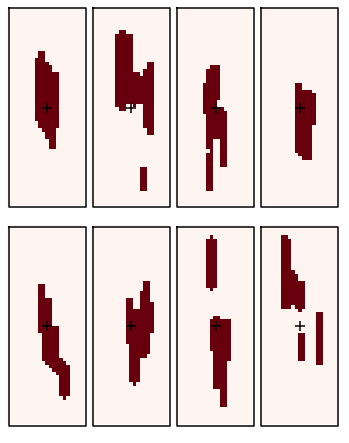

In [126]:
from skimage import draw
import scipy.ndimage
import matplotlib.pyplot as plt
import numpy as np
import cv2
from cv2 import resize

fig = plt.figure(figsize=(6,8))

for n in range(1,9):

    ax = fig.add_subplot(2, 4, n)

    size = [22, 57.2]
    img = np.zeros([220, 572])

    for i in range(3):

        c_x = int(3 * np.random.randn(1) + 11)*10
        c_y = int(5 * np.random.randn(1) + 57.2/2)*10

        rr, cc = draw.disk((c_x,c_y), radius=int(np.random.randint(20,50,1)), shape=img.shape)
        img[rr, cc] = 1

        c_x = int(3 * np.random.randn(1) + 11)*10
        c_y = int(5 * np.random.randn(1) + 57.2/2)*10

        rr, cc = draw.rectangle((c_x, c_y), (c_x + int(np.random.randint(30, 70, 1)), c_y + int(np.random.randint(30, 70, 1))), shape=img.shape)
        img[rr, cc] = 1

    img = resize(img, (22,57), interpolation=cv2.INTER_NEAREST)
    img = scipy.ndimage.gaussian_filter(img, 1)
    img[img<0.5] = 0
    img[img>0] = 1
    ax.imshow(img, cmap="Reds")
    ax.plot([0,0,22,22, 0], [0,57,57, 0, 0], color="k")
    ax.scatter(11,57/2,100, marker="+", color="k")
    plt.subplots_adjust(wspace=0.02, hspace=0.01)

    #ax.set_xlim((0,572))
    #ax.set_ylim((0,220))
    ax.axis("off")
#plt.tight_layout()
